In [2]:
import numpy as np
from scipy.optimize import newton 

constants = {
    "T_STANDARD": 288.7056,  # Temperature in Kelvin
    "P_STANDARD": 101325.0,    # Pressure in Pascal
    "R": 8.31446261815324,
    "MW_AIR": 28.97,  # molecular weight of air at standard conditions, g/mol
    "RHO_WATER": 999.0170125317171,  # density of water @60F, 1atm (kg/m^3) according to IAPWS-95 standard. Calculate rho at different conditions by:  chemicals.iapws95_rho(288.706, 101325) (K, pascal)
}

def Tb_mw(Tb, mw):
    """
    source: [2] (eq 2), or [3] (eq 2.42 + constants from Table 4.5)
    """
    return -mw + ((6.97996 - np.log(1080 - Tb))/0.01964) ** (3/2)

def liq_ghv_sg(ghv, API):
    """
    notes: gross heating value (ghv, also known has high heating value) vs. API gravity for fuel liquids
    source: [4]
    units: ghv (Btu/lb)
    working range: 0 < API < 60
    https://www.cheresources.com/invision/blog/4/entry-297-heats-of-combustion-correlations/#:~:text=HHV%20%2F%20LHV%20%3D%20Higher%20%2F%20Lower%20Heating,molecular%20weight%20of%20the%20fuel%20gas%20%28%3D%20SG%2A28.96%29

    """
    return -ghv + 17721 + 89.08 * API - 0.348 * API**2 + 0.009518 * API**3

def gas_ghv_sg(ghv, sg):
    """
    notes: gross heating value (ghv, also known has high heating value) vs. gas specific gravity for fuel gases
    source: [3]
    units: ghv (Btu/scf)
    working range: < 2.0 sg
    https://www.cheresources.com/invision/blog/4/entry-297-heats-of-combustion-correlations/#:~:text=HHV%20%2F%20LHV%20%3D%20Higher%20%2F%20Lower%20Heating,molecular%20weight%20of%20the%20fuel%20gas%20%28%3D%20SG%2A28.96%29

    """
    return -ghv + 229.60 + 1321 * sg + 207.97 * sg**2 - 57.084 * sg**3


def gas_nhv_sg(nhv, sg):
    """
    notes: net heating value (nhv, also known has low heating value) vs. gas specific gravity for fuel gases
    source: [3]
    units: nhv (Btu/scf)
    """
    return -nhv + 186.37 + 1219.3 * sg + 206.93 * sg**2 - 56.936 * sg**3

def Tb_mw_sg(Tb, mw, sg_liq):
    """
    source: [1] (eq 2.51)
    notes:
    working range: mw 70~700, Tb 300~850K (90-1050F), API 14.4~93.
    errors: 3.5% for mw < 300, 4.7% for mw > 300.
    """
    return -mw + 42.965 * (np.exp(2.097e-4 * Tb - 7.78712 * sg_liq + 2.08476e-3 * Tb * sg_liq)) * Tb**1.26007 * sg_liq**4.983098


def mw_sg_liq(mw, sg_liq):
    """
    source: [2] (eq 3), or [3] (eq 2.42 + constants from Table 4.5). Valid upto C7 ~ C100. Off by 11% for C6.
    """
    return -sg_liq + 1.07 - np.exp(3.56073 - 2.93886 * mw ** 0.1)


def API_sg_liq(API, sg_liq):
    """
    source: [1] (eq 2.4)
    notes: valid for all liquid
    """
    return -API + 141.5 / sg_liq - 131.5


def mw_sg_gas(mw, sg_gas):
    """
    source: [1] (eq 2.6)
    notes: valid for all gas
    """
    sg_air = constants['MW_AIR']

    return mw / sg_air - sg_gas

def sg_liq(rhol_60F_mass):
    """
    rhol_60F_mass = Liquid mass densities at 60 °F, [kg/m^3].
    Water liquid density at 60F is assumed to be 999.0170125317171 kg/m^3 by default
    """
    return rhol_60F_mass / constants['RHO_WATER']

"""
.. [1] Riazi, M. R.: "Characterization and Properties of Petroleum Fractions," first edition (1985), West Conshohocken, Pennsylvania: ASTM International`
.. [2] Nourozieh, H., Kariznovi,  M., and Abedi, J.: "Measurement and Modeling of Solubility and Saturated - Liquid Density and Viscosity for Methane / Athabasca - Bitumen Mixtures," paper SPE-174558-PA (2016). `(link) <https://onepetro.org/SJ/article/21/01/180/205922/Measurement-and-Modeling-of-Solubility-and>`__
.. [3] API Technical Databook GPA Publication 2145-82
.. [4] Maxwell's Databook on Hydrocarbons
"""

'\n.. [1] Riazi, M. R.: "Characterization and Properties of Petroleum Fractions," first edition (1985), West Conshohocken, Pennsylvania: ASTM International`\n.. [2] Nourozieh, H., Kariznovi,  M., and Abedi, J.: "Measurement and Modeling of Solubility and Saturated - Liquid Density and Viscosity for Methane / Athabasca - Bitumen Mixtures," paper SPE-174558-PA (2016). `(link) <https://onepetro.org/SJ/article/21/01/180/205922/Measurement-and-Modeling-of-Solubility-and>`__\n.. [3] API Technical Databook GPA Publication 2145-82\n.. [4] Maxwell\'s Databook on Hydrocarbons\n'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)

C:\Users\EricKim\AppData\Local\Temp\ipykernel_27956\3318444582.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_excel("GPA 2145-16 Compound Properties Table - English.xlsx")
df = df.dropna(subset=['Gross Heating Value Ideal Gas [Btu/ft^3]']).reset_index()

cols = ['Compound', 'CAS', 'Formula', 'Gross Heating Value Ideal Gas [Btu/ft^3]', 'Molar Mass [g/mol]', 
        'Gross Heating Value Ideal Gas [Btu/lbm]',
        'Ideal Gas Relative Density @60F:1atm',
       'Liq. Relative Density @60F:1atm', 'API Gravity @60F:1atm']
df = df[cols]

In [3]:
df.head()

,Compound,CAS,Formula,Gross Heating Value Ideal Gas [Btu/ft^3],Molar Mass [g/mol],Gross Heating Value Ideal Gas [Btu/lbm],Ideal Gas Relative Density @60F:1atm,Liq. Relative Density @60F:1atm,API Gravity @60F:1atm
0,methane,74-82-8,CH4,1010.0,16.0425,23892.0,0.5539,0.30000,340.00
1,ethane,74-84-0,C2H6,1769.7,30.0690,22334.0,1.0382,0.35628,265.66
2,propane,74-98-6,C3H8,2516.1,44.0956,21654.0,1.5225,0.50719,147.49
3,isobutane,75-28-5,C4H10,3251.9,58.1222,21232.0,2.0068,0.56283,119.91
4,n-butane,106-97-8,C4H10,3262.3,58.1222,21300.0,2.0068,0.58420,110.71


In [4]:
def is_paraffinic(formula):
    if formula.startswith('C') and 'H' in formula:
        parts = formula[1:].split('H')
        # Attempt to parse the carbon count, default to 1 if not explicitly mentioned
        carbon_count = int(parts[0]) if parts[0].isdigit() else 1
        
        # Attempt to parse the hydrogen count, ensuring the substring is numeric
        hydrogen_count = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else 0
        
        # Checking the paraffinic formula CnH2n+2
        return hydrogen_count == 2 * carbon_count + 2
    return False

In [6]:
# Defining BTEX compounds
btex_substrings = ['xylene', 'benzene', 'toluene'] 
aromatic_substrings = ['xylene', 'benzene', 'toluene', 'styrene', 'naphthalene']
naphethenic_substrings = ['cyclo']

df['Is BTEX'] = df['Compound'].str.contains('|'.join(btex_substrings), case=False, na=False)
df['Is Aromatic'] = df['Compound'].str.contains('|'.join(aromatic_substrings), case=False, na=False)
df['Is Naphthenic'] = df['Compound'].str.contains('|'.join(naphethenic_substrings), case=False, na=False)

# Creating the "Is Hydrocarbon" column
df['Is Hydrocarbon'] = df['Formula'].apply(lambda x: 'C' in x and 'H' in x)
df['Is Hydroxyl'] = df['Formula'].apply(lambda x: 'H' in x and 'O' in x)
df['Is Paraffinic'] = df['Formula'].apply(is_paraffinic)

BTEX_idx = df[df['Is BTEX'] == True].index
aromatic_idx = df[df['Is Aromatic'] == True].index
non_HC_idx = df[df['Is Hydrocarbon'] == False].index
hydroxyl_idx = df[df['Is Hydroxyl'] == True].index
naphethenic_idx = df[df['Is Naphthenic'] == True].index
paraffin_idx = df[df['Is Paraffinic'] == True].index
other_HC_idx = list(set(df.index) - set(aromatic_idx) - set(non_HC_idx) - set(hydroxyl_idx) - set(naphethenic_idx) - set(paraffin_idx))

df['Others'] = False
df['Others'].loc[other_HC_idx] = True

C:\Users\EricKim\AppData\Local\Temp\ipykernel_27956\3132212663.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Others'].loc[other_HC_idx] = True


In [7]:
df.to_csv('GPA 2145-16 Compound Properties Table - English - Truncated and PNA Identified.csv', index=False)

# Begin

In [9]:
df = pd.read_csv('GPA 2145-16 Compound Properties Table - English - Truncated and PNA Identified.csv')

In [10]:
# Labeling for displaying texts
labels = ['methane', 'propane', 'n-butane', 'n-heptane', 'n-octane', 'n-decane', 'cyclohexane', 'cyclopentane', 'ethane',
'n-dodecane','n-tetradecane','n-hexadecane', 'methanol', 'ethanol', 'naphthalene', 'isobutylcyclopentane', 'hydrogen',
 'sulfur dioxide', 'hydrogen sulfide', 'toluene', 'benzene', 'm-xylene', 'pentylbenzene', 'hexylbenzene',
         'propylene', '1-butene'
         ]
df['Display Text'] = df['Compound'].isin(labels)
df.head(3)

,Compound,CAS,Formula,Gross Heating Value Ideal Gas [Btu/ft^3],Molar Mass [g/mol],Gross Heating Value Ideal Gas [Btu/lbm],Ideal Gas Relative Density @60F:1atm,Liq. Relative Density @60F:1atm,API Gravity @60F:1atm,Is BTEX,Is Aromatic,Is Naphethenic,Is Hydrocarbon,Is Hydroxyl,Is Paraffinic,Others,Display Text
0,methane,74-82-8,CH4,1010.0,16.0425,23892.0,0.5539,0.30000,340.00,False,False,False,True,False,True,False,True
1,ethane,74-84-0,C2H6,1769.7,30.0690,22334.0,1.0382,0.35628,265.66,False,False,False,True,False,True,False,True
2,propane,74-98-6,C3H8,2516.1,44.0956,21654.0,1.5225,0.50719,147.49,False,False,False,True,False,True,False,True


In [11]:
BTEX_idx = df[df['Is BTEX'] == True].index
aromatic_idx = df[df['Is Aromatic'] == True].index
non_HC_idx = df[df['Is Hydrocarbon'] == False].index
hydroxyl_idx = df[df['Is Hydroxyl'] == True].index
paraffinic_idx = df[df['Is Paraffinic'] == True].index
naphethenic_idx = df[df['Is Naphethenic'] == True].index
other_idx = df[df['Others'] == True].index
whole_idx = list(df.index)

In [12]:
x = df['Molar Mass [g/mol]']
#x = df['Ideal Gas Relative Density @60F:1atm']
#x = df['API Gravity @60F:1atm']
#x = df['Gross Heating Value Ideal Gas [Btu/ft^3]']
#x = df['Liq. Relative Density @60F:1atm']
#x = df['API Gravity @60F:1atm']
#x = df['Gross Heating Value Ideal Gas [Btu/lbm]']

#y = df['Molar Mass [g/mol]']
#y = df['Ideal Gas Relative Density @60F:1atm']
#y = df['API Gravity @60F:1atm']
y = df['Gross Heating Value Ideal Gas [Btu/ft^3]']
#y = df['Liq. Relative Density @60F:1atm']
#y = df['API Gravity @60F:1atm']
#y = df['Gross Heating Value Ideal Gas [Btu/lbm]']


#y = df['Gross Heating Value Ideal Gas [Btu/ft^3]'] * (379.5 / y)

In [13]:
df[df['Others'] == True][['Compound', 'Formula', 'Molar Mass [g/mol]', 'Gross Heating Value Ideal Gas [Btu/ft^3]']]

,Compound,Formula,Molar Mass [g/mol],Gross Heating Value Ideal Gas [Btu/ft^3]
12,ethylene,C2H4,28.0532,1599.7
13,propylene,C3H6,42.0797,2333.0
24,ethyne,C2H2,26.0373,1474.3
25,"1,2-propadiene",C3H4,40.0639,2202.3
26,"1,3-butadiene",C4H6,54.0904,2879.9
27,"1,2-butadiene",C4H6,54.0904,2940.0
28,2-methylpropene,C4H8,56.1063,3061.1
29,1-butene,C4H8,56.1063,3079.9
30,(E)-2-butene,C4H8,56.1063,3068.1
31,(Z)-2-butene,C4H8,56.1063,3072.3


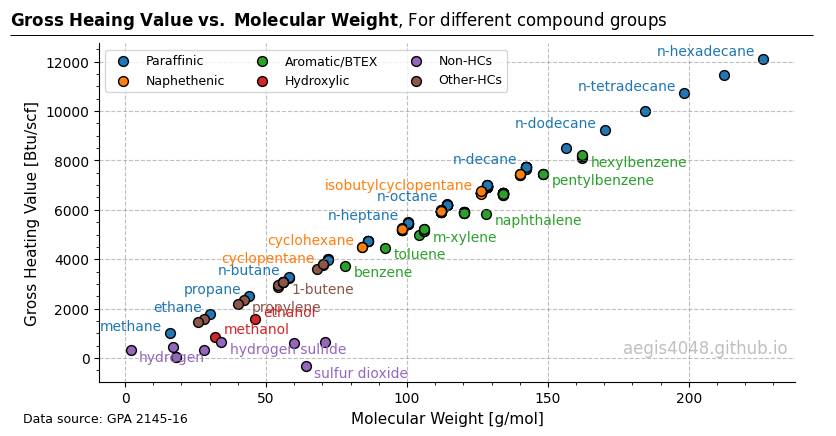

In [14]:
fig, ax = plt.subplots(figsize=(8, 4.5))

alpha = 1
_1 = ax.scatter(x.loc[paraffinic_idx], y.loc[paraffinic_idx], s=50, edgecolor='k', alpha=alpha, label='Paraffinic')
_2 = ax.scatter(x.loc[naphethenic_idx], y.loc[naphethenic_idx], s=50, edgecolor='k', alpha=alpha, label='Naphethenic')
_3 = ax.scatter(x.loc[aromatic_idx], y.loc[aromatic_idx], s=50, edgecolor='k', alpha=alpha, label='Aromatic/BTEX')
_4 = ax.scatter(x.loc[hydroxyl_idx], y.loc[hydroxyl_idx], s=50, edgecolor='k', alpha=alpha, label='Hydroxylic')
_5 = ax.scatter(x.loc[non_HC_idx], y.loc[non_HC_idx], s=50, edgecolor='k', alpha=alpha, label='Non-HCs')
_6 = ax.scatter(x.loc[other_idx], y.loc[other_idx], s=50, edgecolor='k', alpha=alpha, label='Other-HCs')

c1 = _1.get_facecolor()[0]
c2 = _2.get_facecolor()[0]
c3 = _3.get_facecolor()[0]
c4 = _4.get_facecolor()[0]
c5 = _5.get_facecolor()[0]
c6 = _6.get_facecolor()[0]

ax.legend(fontsize=9, ncol=3)

#selected_idx = excluded_idx
selected_idx = random.sample(whole_idx, k=int(len(whole_idx) * 0.1)) 
texts = df['Compound']
for i, txt in enumerate(texts):
    if df['Display Text'].loc[i]:
        c = c5
        ha ='left'
        va = 'top'
        
        if df['Is Paraffinic'].loc[i]: 
            c = c1
            ha ='right'
            va = 'bottom'
        if df['Is Naphethenic'].loc[i]:
            c = c2
            ha ='right'
            va = 'bottom'
        if df['Is Aromatic'].loc[i]:
            c = c3
            va = 'top'
            ha = 'left'
        if df['Is Hydroxyl'].loc[i]:
            c = c4
            va = 'bottom'
            ha = 'left'
        if df['Others'].loc[i]:
            c = c6
            va = 'top'
            ha = 'left'
        
        if ha == 'left':
            icr = 3
        else:
            icr= -3
        
        ax.annotate(txt, (x.loc[i] + icr, y.iloc[i]), fontsize=10, c=c, ha=ha, va=va)

ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
#ax.grid(axis='y', which='minor', linestyle='--', color='grey', alpha=0.2)
#ax.grid(axis='x', which='minor', color='grey', linestyle='--', alpha=0.2)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight [g/mol]', fontsize=11)
ax.set_ylabel('Gross Heating Value [Btu/scf]', fontsize=11)
ax.text(0.99, 0.1, 'aegis4048.github.io', fontsize=12, ha='right', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

#ax.set_xlim(0, 1)
#ax.set_ylim(10000, 30000)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('Gross Heaing Value vs. Molecular Weight')
plain_txt = r', For different compound groups'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=12, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.annotate('Data source: GPA 2145-16', xy=(-0.11, -.12), xycoords='axes fraction', fontsize=9)

fig.tight_layout()

In [24]:
#x = df['Molar Mass [g/mol]']
#x = df['Ideal Gas Relative Density @60F:1atm']
#x = df['API Gravity @60F:1atm']
#x = df['Gross Heating Value Ideal Gas [Btu/ft^3]']
x = df['Liq. Relative Density @60F:1atm']
#x = df['API Gravity @60F:1atm']
#x = df['Gross Heating Value Ideal Gas [Btu/lbm]']

#y = df['Molar Mass [g/mol]']
#y = df['Ideal Gas Relative Density @60F:1atm']
#y = df['API Gravity @60F:1atm']
#y = df['Gross Heating Value Ideal Gas [Btu/ft^3]']
#y = df['Liq. Relative Density @60F:1atm']
#y = df['API Gravity @60F:1atm']
y = df['Gross Heating Value Ideal Gas [Btu/lbm]']


#y = df['Gross Heating Value Ideal Gas [Btu/ft^3]'] * (379.5 / y)

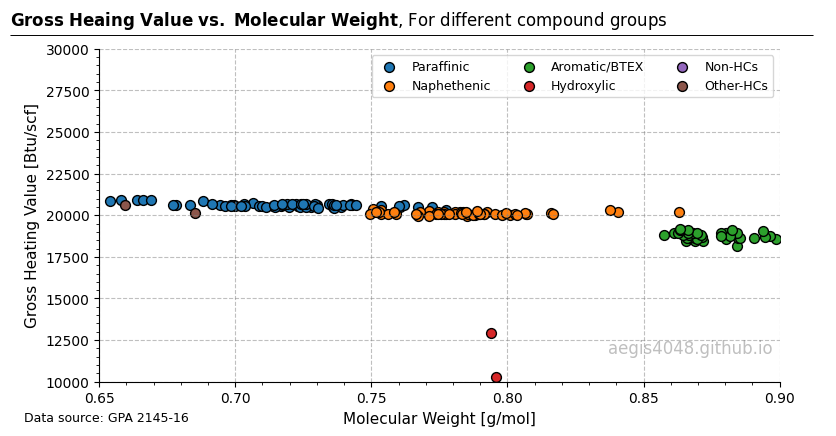

In [28]:
fig, ax = plt.subplots(figsize=(8, 4.5))

alpha = 1
_1 = ax.scatter(x.loc[paraffinic_idx], y.loc[paraffinic_idx], s=50, edgecolor='k', alpha=alpha, label='Paraffinic')
_2 = ax.scatter(x.loc[naphethenic_idx], y.loc[naphethenic_idx], s=50, edgecolor='k', alpha=alpha, label='Naphethenic')
_3 = ax.scatter(x.loc[aromatic_idx], y.loc[aromatic_idx], s=50, edgecolor='k', alpha=alpha, label='Aromatic/BTEX')
_4 = ax.scatter(x.loc[hydroxyl_idx], y.loc[hydroxyl_idx], s=50, edgecolor='k', alpha=alpha, label='Hydroxylic')
_5 = ax.scatter(x.loc[non_HC_idx], y.loc[non_HC_idx], s=50, edgecolor='k', alpha=alpha, label='Non-HCs')
_6 = ax.scatter(x.loc[other_idx], y.loc[other_idx], s=50, edgecolor='k', alpha=alpha, label='Other-HCs')

c1 = _1.get_facecolor()[0]
c2 = _2.get_facecolor()[0]
c3 = _3.get_facecolor()[0]
c4 = _4.get_facecolor()[0]
c5 = _5.get_facecolor()[0]
c6 = _6.get_facecolor()[0]

ax.legend(fontsize=9, ncol=3)

#selected_idx = excluded_idx
selected_idx = random.sample(whole_idx, k=int(len(whole_idx) * 0.1)) 
texts = df['Compound']
for i, txt in enumerate(texts):
    if df['Display Text'].loc[i]:
        c = c5
        ha ='left'
        va = 'top'
        
        if df['Is Paraffinic'].loc[i]: 
            c = c1
            ha ='right'
            va = 'bottom'
        if df['Is Naphethenic'].loc[i]:
            c = c2
            ha ='right'
            va = 'bottom'
        if df['Is Aromatic'].loc[i]:
            c = c3
            va = 'top'
            ha = 'left'
        if df['Is Hydroxyl'].loc[i]:
            c = c4
            va = 'bottom'
            ha = 'left'
        if df['Others'].loc[i]:
            c = c6
            va = 'top'
            ha = 'left'
        
        if ha == 'left':
            icr = 3
        else:
            icr= -3
        
        ax.annotate(txt, (x.loc[i] + icr, y.iloc[i]), fontsize=10, c=c, ha=ha, va=va)

ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
#ax.grid(axis='y', which='minor', linestyle='--', color='grey', alpha=0.2)
#ax.grid(axis='x', which='minor', color='grey', linestyle='--', alpha=0.2)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight [g/mol]', fontsize=11)
ax.set_ylabel('Gross Heating Value [Btu/scf]', fontsize=11)
ax.text(0.99, 0.1, 'aegis4048.github.io', fontsize=12, ha='right', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

ax.set_xlim(0.65, 0.9)
ax.set_ylim(10000, 30000)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('Gross Heaing Value vs. Molecular Weight')
plain_txt = r', For different compound groups'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=12, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.annotate('Data source: GPA 2145-16', xy=(-0.11, -.12), xycoords='axes fraction', fontsize=9)

fig.tight_layout()

# Make a plot for PNA prediction with sg, I, and viscosity from API

page 208, 1039, 199, 212 of API book


In [15]:
sg_liq = 0.8267 # Shamrock
mw_range = 'light'

if mw_range == 'light':
    a = -13.359
    b = 14.4591
    c = -1.41344
    d = 23.9825
    e = -23.333
    f = 0.81517
    g = -9.6235
    h = 8.8739
    i = 0.59827
    
    
elif mw_range == 'heavy':
    a = 2.5737
    b = 1.0133
    c = -3.573
    d = 2.464
    e = -3.6701
    f = 1.96312
    g = -4.0377
    h = 2.6568
    i = 1.60988
    
else:
    raise TypeError("Unsupported MW range")
    
VGF = 1

0) Use single carbon number approach. 
1) Convert sg_liq to mw using correlation.
2) Obtain Tb(mw, sg_liq) -> I can use boiling points and specific gravity of the GPA table. 
3) go to page 1039 and calculate viscosity. K factor ca be calculated with pg 199.
4) calculate refractive index
5) Calculate aromatic fraction
7) Calculate MW from gas GHV. 
8) Convert gas GHV (Btu/ft) to liquid GHV (Btu/lbm) - these two are linearly correlated. You need MW value for conversion
9) Convert liquid GHV (Btu/lbm) to density.- These are decently linear enough, but perfect, but good enough. Or use the API correlation. API correlation works between 0 to 60 API

Scatter plot of sg vs. aromatic fraction. Make three plots (paraffinic, aromatic, naphethenic)

After the model is developed, check with Brazos C6+ data to confirm that estimating sq_liq from sg->ghv makes sense

In [16]:
mw = newton(lambda mw: mw_sg_liq(mw, sg_liq=0.8267), x0=90, maxiter=500)
mw

192.9455415614911

In [17]:
#mw = newton(lambda mw: mw_sg_gas(mw, 3.453), x0=90, maxiter=500)
mw

192.9455415614911

In [18]:
mw

192.9455415614911

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
x = df['Molar Mass [g/mol]']
#x = df['Ideal Gas Relative Density @60F:1atm']
#x = df['API Gravity @60F:1atm']
#x = df['Gross Heating Value Ideal Gas [Btu/ft^3]']
#x = df['Liq. Relative Density @60F:1atm']
#x = df['API Gravity @60F:1atm']
#x = df['Gross Heating Value Ideal Gas [Btu/lbm]']

#y = df['Molar Mass [g/mol]']
#y = df['Ideal Gas Relative Density @60F:1atm']
#y = df['API Gravity @60F:1atm']
y = df['Gross Heating Value Ideal Gas [Btu/ft^3]']
#y = df['Liq. Relative Density @60F:1atm']
#y = df['API Gravity @60F:1atm']
#y = df['Gross Heating Value Ideal Gas [Btu/lbm]']


#y = df['Gross Heating Value Ideal Gas [Btu/ft^3]'] * (379.5 / y)

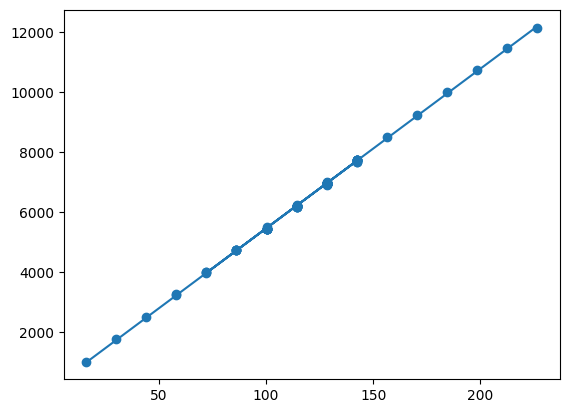

In [21]:
x = x.loc[paraffin_idx]
y = y.loc[paraffin_idx]
X = x.values.reshape(-1, 1)

# Ordinary Least Squares
ols = LinearRegression().fit(X, y)
y_pred_ols = ols.predict(X)
coefs_ols = ols.coef_
intercept_ols = ols.intercept_


plt.scatter(x, y)
plt.plot(x, y_pred_ols)

In [55]:
coefs_ols 

array([53.12934909])

In [56]:
intercept_ols 

147.95345718461067

In [57]:
ghv_gas = 4774
mw = (ghv_gas - intercept_ols) / coefs_ols[0]
mw

87.0713950366714

In [58]:
mw = mw
ghv_liq = ghv_gas * (379.5 / mw)
ghv_liq

20807.441976058402

In [59]:
#x = df['Molar Mass [g/mol]']
#x = df['Ideal Gas Relative Density @60F:1atm']
#x = df['API Gravity @60F:1atm']
#x = df['Gross Heating Value Ideal Gas [Btu/ft^3]']
x = df['Liq. Relative Density @60F:1atm']
#x = df['API Gravity @60F:1atm']
#x = df['Gross Heating Value Ideal Gas [Btu/lbm]']

#y = df['Molar Mass [g/mol]']
#y = df['Ideal Gas Relative Density @60F:1atm']
#y = df['API Gravity @60F:1atm']
#y = df['Gross Heating Value Ideal Gas [Btu/ft^3]']
#y = df['Liq. Relative Density @60F:1atm']
#y = df['API Gravity @60F:1atm']
y = df['Gross Heating Value Ideal Gas [Btu/lbm]']


#y = df['Gross Heating Value Ideal Gas [Btu/ft^3]'] * (379.5 / y)

(20000.0, 21500.0)

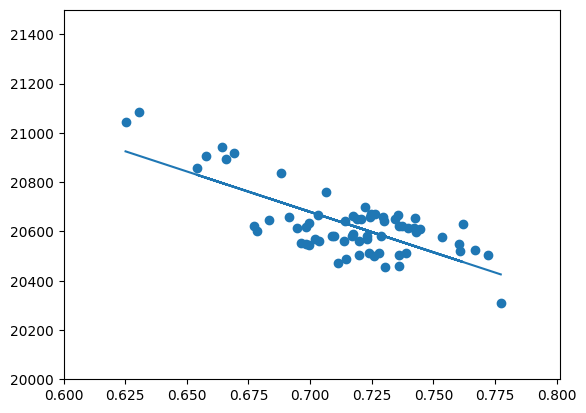

In [43]:
idx_pentane = x[x > 0.6].index

x_new = x.loc[idx_pentane]
y_new = y.loc[idx_pentane]

x = x.loc[paraffin_idx]
y = y.loc[paraffin_idx]

idx_pentane = x[x > 0.6].index
x_new = x.loc[idx_pentane]
y_new = y.loc[idx_pentane]
X = x_new.values.reshape(-1, 1)

# Ordinary Least Squares
ols = LinearRegression().fit(X, y_new)
y_pred_ols = ols.predict(X)
coefs_ols = ols.coef_
intercept_ols = ols.intercept_


plt.scatter(x, y)
plt.plot(x_new, y_pred_ols)
plt.xlim(0.6,)
plt.ylim(20000, 21500)

In [61]:
coefs_ols

array([-3280.40482578])

In [62]:
intercept_ols

22975.67560221096

In [63]:
ghv_liq

20807.441976058402

In [64]:
(ghv_liq - intercept_ols)/coefs_ols[0]

0.6609652592618567

In [65]:
def liq_ghv_sg(ghv, API):
    """
    notes: gross heating value (ghv, also known has high heating value) vs. API gravity for fuel liquids
    source: [4]
    units: ghv (Btu/lb)
    working range: 0 < API < 60
    https://www.cheresources.com/invision/blog/4/entry-297-heats-of-combustion-correlations/#:~:text=HHV%20%2F%20LHV%20%3D%20Higher%20%2F%20Lower%20Heating,molecular%20weight%20of%20the%20fuel%20gas%20%28%3D%20SG%2A28.96%29

    """
    return -ghv + 17721 + 89.08 * API - 0.348 * API**2 + 0.009518 * API**3

In [66]:
API = newton(lambda API: liq_ghv_sg(ghv_liq, API), x0=45, maxiter=500)

sg = 141.5 / (API + 131.5)

print('sg =', sg)
print('API =', API)

sg = 0.8505237992189714
API = 34.86806651376273


In [67]:
newton(lambda ghv_liq: liq_ghv_sg(ghv_liq, API=72.6), x0=45, maxiter=500)

25996.114521167998

In [68]:
API = 72.6
17721 + 89.08 * API - 0.348 * API**2 + 0.009518 * API**3

25996.114521167998

In [69]:
ghv_liq

20807.441976058402

In [70]:
df.loc[paraffin_idx].sort_values(by='Liq. Relative Density @60F:1atm')[[
    'Compound',
    'Formula',
    'Gross Heating Value Ideal Gas [Btu/lbm]', 
    'Liq. Relative Density @60F:1atm',
]].head()

,Compound,Formula,Gross Heating Value Ideal Gas [Btu/lbm],Liq. Relative Density @60F:1atm
0,methane,CH4,23892.0,0.30000
1,ethane,C2H6,22334.0,0.35628
2,propane,C3H8,21654.0,0.50719
3,isobutane,C4H10,21232.0,0.56283
4,n-butane,C4H10,21300.0,0.58420


In [71]:
df

,Compound,CAS,Formula,Gross Heating Value Ideal Gas [Btu/ft^3],Molar Mass [g/mol],Gross Heating Value Ideal Gas [Btu/lbm],Ideal Gas Relative Density @60F:1atm,Liq. Relative Density @60F:1atm,API Gravity @60F:1atm,Is BTEX,Is Aromatic,Is Naphethenic,Is Hydrocarbon,Is Hydroxyl,Is Paraffinic,Others,Display Text
0,methane,74-82-8,CH4,1010.00,16.0425,23892.0,0.55390,0.300000,340.0000,False,False,False,True,False,True,False,True
1,ethane,74-84-0,C2H6,1769.70,30.0690,22334.0,1.03820,0.356280,265.6600,False,False,False,True,False,True,False,True
2,propane,74-98-6,C3H8,2516.10,44.0956,21654.0,1.52250,0.507190,147.4900,False,False,False,True,False,True,False,True
3,isobutane,75-28-5,C4H10,3251.90,58.1222,21232.0,2.00680,0.562830,119.9100,False,False,False,True,False,True,False,False
4,n-butane,106-97-8,C4H10,3262.30,58.1222,21300.0,2.00680,0.584200,110.7100,False,False,False,True,False,True,False,True
5,isopentane,78-78-4,C5H12,4000.90,72.1488,21044.0,2.49110,0.625140,94.8480,False,False,False,True,False,True,False,False
6,n-pentane,109-66-0,C5H12,4008.70,72.1488,21085.0,2.49110,0.630710,92.8500,False,False,False,True,False,True,False,False
7,n-hexane,110-54-3,C6H14,4755.90,86.1754,20943.0,2.97540,0.664060,81.5820,False,False,False,True,False,True,False,False
8,n-heptane,142-82-5,C7H16,5502.60,100.2019,20839.0,3.45970,0.688230,74.1010,False,False,False,True,False,True,False,True
9,n-octane,111-65-9,C8H18,6249.00,114.2285,20760.0,3.94400,0.706550,68.7680,False,False,False,True,False,True,False,True


In [73]:
api = 96.72
ghv = 17762 + 66.6*api - 0.316 * api**2 - 0.0014*api**3
ghv 

19980.7392201728

# Promax data poitns

In [19]:
mw = 100.88

_1_sg = 0.9
_1_ghv = 44.548 # kJ/g

_2_sg = 0.85
_2_ghv = 45.4843

_3_sg = 0.8
_3_ghv = 46.3166

_4_sg = 0.75
_4_ghv = 46.9504

_5_sg = 0.7
_5_ghv = 47.2324

_6_sg = 0.65
_6_ghv = 46.9116


_7_sg = 0.6
_7_ghv = 45.5682

_8_sg = 0.625
_8_ghv = 46.4035

_9_sg = 0.95
_9_ghv = 43.5668

_10_sg = 1
_10_ghv = 42.5774

_11_sg = 0.5
_11_ghv = 36.3808

_12_sg = 0.73
_12_ghv = 47.1167

a = [_1_sg, _2_sg, _3_sg, _4_sg, _5_sg, _6_sg, _7_sg, _8_sg, _9_sg, _10_sg, _11_sg, _12_sg]
b = [_1_ghv, _2_ghv, _3_ghv, _4_ghv, _5_ghv, _6_ghv, _7_ghv, _8_ghv, _9_ghv, _10_ghv, _11_ghv, _12_ghv]

In [28]:
from pint import UnitRegistry
import matplotlib.pyplot as plt

ureg = UnitRegistry()

def calc_ghvs(sg):
    return (51.9 - 8.8 * sg**2)

def calc_api(sg):
    return 141.5/sg - 131.5

def calc_ghv_api(api):
    ghv = 17721 + 89.08 * api - 0.348 * api**2 + 0.009518*api**3
    ghv = (ghv * ureg.BTU / ureg.pound).to(ureg.kJ / ureg.gram)._magnitude
    
    return ghv

def calc_sg(api):
    return 141.5 / (api + 131.5)

apis = [calc_api(s) for s in a]
ghv_api = [calc_ghv_api(api) for api in apis]
combined = list(zip(apis, ghv_api))
sorted_combined = sorted(combined)
sorted_api, sorted_ghv = zip(*sorted_combined)
sorted_sg = [calc_sg(api) for api in sorted_api]


b2 = [calc_ghvs(s) for s in a]
combined = list(zip(a, b2))
sorted_combined = sorted(combined)
sorted_a, sorted_b2 = zip(*sorted_combined)

In [42]:
def calc_ghv_liq_to_gas(ghv_liq):

    ghv_kj_per_g = ghv_liq * ureg.kilojoule / ureg.gram  # Replace 1 with your actual value
    ghv_liq = ghv_kj_per_g.to(ureg.BTU / ureg.pound)._magnitude
    
    mw = 100.88
    ghv_gas = ghv_liq * mw / 379.6
    
    return ghv_gas

Text(0, 0.5, 'Gross Liquid Heating Value [kJ/g]')

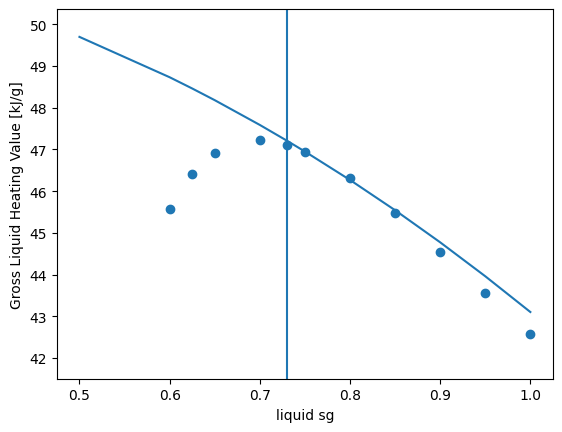

In [43]:
plt.scatter(a, b)
plt.plot(sorted_a, sorted_b2)
#plt.plot(sorted_sg, sorted_ghv)
plt.ylim(41.5, None)
plt.axvline(x=0.73)
plt.xlabel('liquid sg')
plt.ylabel('Gross Liquid Heating Value [kJ/g]')

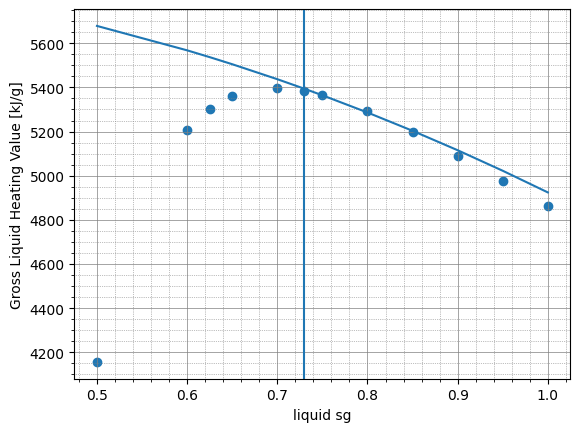

In [45]:
b_ = [calc_ghv_liq_to_gas(ghv_liq) for ghv_liq in b]
sorted_b2_ = [calc_ghv_liq_to_gas(ghv_liq) for ghv_liq in sorted_b2]

plt.scatter(a, b_)
plt.plot(sorted_a, sorted_b2_)
#plt.plot(sorted_sg, sorted_ghv)
#plt.ylim(41.5, None)
plt.axvline(x=0.73)
plt.xlabel('liquid sg')
plt.ylabel('Gross Liquid Heating Value [kJ/g]')

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')